### I. Introduction
This project in neural network computing seeks to develop a predictive model for gold prices.  Price forecasting is performed by running a RNN on four different partitions of data: 1-min prices, 5-min prices, 60-min prices, and 120-min prices.  By plotting these predictions, forecasted price regression can be established.  The neural network utilized is run on GPUs to allow for rapid experimentation and adjustment of hyperparameters.

### II. Structure
To test the data features and machine learning parameters against a benchmark (linear regression), this project is divided into five experimentation sections - testing for runtime, loss and hyperparameters - and a sixth conclusion section.  Objectives are defined at the beginning of each section.

   ><b>  Section A - Data Retrieval </b>\
   ><b>  Section B - Linear Regression Baseline </b>\
   ><b>  Section C - Feature Selection </b>\
   ><b>  Section D - Neural Network Training </b>\
   ><b>  Section E - Comparative Evaluation of Model Quality </b>\
   ><b>  Section F - Analysis and Conclusion </b>
   
   

### Libraries import

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, LeakyReLU, Dropout
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import load_model

import seaborn as sns

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### GPU test

In [3]:
# clear keras session
K.clear_session()

# (3) verify GPU available (AWS)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11607657017868547044
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6603852626551178272
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13673575611676080656
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1162280960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6286530679156674540
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


### Section A - Data Retrieval
Data is sourced from the Polygon.io API (paid service) and stored in a SQLite local database file.  We utilized SQLite for data storage to add data redunancy and to remove local data file dependencies (i.e., csv files).  We created CRUD functions that automate the Polygon API data calls and local database operations (data model creation, table creation and storage).

The following data was sourced for experimentation with the target variable as the closing price of GLD:

Dataset:  500,000+ minute bars for each of the stock tickers: 
  - GLD (gold etf) 
  - HYG (high yield etf) 
  - VIXY (short-term VIX futures ETF)
  - SPY (S&P500 ETF)

The complete set of features, for each stock other than GLD, used to fit the models in Sections C, D, and E (22 in total) were: 
  - open, high, low, close, volume, vwap
  - previous bar's open, high, low, close 

To train the recurrent neural networks in Section D for each price partition (i.e., 120-min data), we used a 5-period lookback (i.e., the timeseries data was created using the 5 previous periods of features). This means that the maximum model complexity would be 100 features for predicting the next period close for gold (GLD).

The results of the feature selection in Section C show the RNN was computed using significantly less than the 100-feature maximum thereby avoiding redundant or irrelevant features.

In [4]:
import requests
import pandas as pd
import datetime as dt
import sqlite3
from sqlite3 import Error
from os import path


api_key = "PUT YOUR KEY HERE"

# Function to pull timeseries data from polygon.io REST API
def get_df_from_polygon(from_date="2015-12-09", to_date="2020-12-09", periodicity="minute",
                       multiplier="1", symbol="SPY", api_key=api_key,
                       order="desc"):
    try:
        req=f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{multiplier}/{periodicity}/{from_date}/{to_date}?sort=asc&limit=120000000&apiKey={api_key}"
        data = {'datetime':[], 'symbol':[], 'open':[], 'high':[], 'low':[], 'vwap':[], 'volume':[], 'close':[]}
        res = requests.get(req).json()['results']
        for res_i in res:
            if len(list(data.keys())) == len(list(res_i.keys())):
                res_i['t'] /= 1000
                res_i['t'] = dt.datetime.utcfromtimestamp(res_i['t']).strftime('%Y-%m-%d %H:%M:%S')
                data['datetime'].append(res_i['t'])
                data['symbol'].append(symbol)
                data['open'].append(res_i['o'])
                data['high'].append(res_i['h'])
                data['low'].append(res_i['l'])
                data['vwap'].append(res_i['vw'])
                data['volume'].append(res_i['v'])
                data['close'].append(res_i['c'])
        df = pd.DataFrame(data=data)
        df.set_index("datetime", inplace=True)
        if order == "desc":
            df.sort_index(ascending=False, inplace=True)
        else:
            df.sort_index(ascending=True, inplace=True)

        return df
    except Exception as e:
        msg = 'error in get_df_from_polygon'
        raise e(msg)


# Helper function to create a database
def create_db(path_dir="./", db_name="market_db.db"):
    """ creates a SQLite database"""
    conn = None
    try:
        abs_path = ''.join([path_dir, db_name])
        if not path.exists(abs_path):
            print(f"Creating database at: {abs_path}")
            conn = sqlite3.connect(''.join([path_dir, db_name]))
        else:
            print(f"Database already exists at: {abs_path}")
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
            
            
# Helper function to create a table
def create_market_table(conn_file="market_db.db", table_name="MACRO_DATA"):
    """ creates a SQLite table"""
    try:
        conn = sqlite3.connect(conn_file)  
        c = conn.cursor()
        c.execute(f'''CREATE TABLE IF NOT EXISTS {table_name}
                 ([datetime] datetime, [symbol] text, [open] double, [high] double, [low] double, [vwap] double, [volume] double, [close] double)''')
        conn.commit()
    except Exception as e:
        msg = 'error in create_market_table'
        raise e(msg)
        
        
# Helper function to create the mastet table
def create_master_market_table(conn_file="market_db.db", table_name="MASTER_MACRO_DATA", columns="([datetime] datetime, [open] float, [high] float, [low] float, [vwap] float, [volume] float, [close] float, [HYG_open] float, [HYG_high] float, [HYG_low] float, [HYG_vwap] float, [HYG_volume] float, [HYG_close] float, [VIXY_open] float, [VIXY_high] float, [VIXY_low] float, [VIXY_vwap] float, [VIXY_volume] float, [VIXY_close] float, [SPY_open] float, [SPY_high] float, [SPY_low] float, [SPY_vwap] float, [SPY_volume] float, [SPY_close] float)"):
    """ creates a SQLite table"""
    try:
        conn = sqlite3.connect(conn_file)  
        c = conn.cursor()
        c.execute(f'''CREATE TABLE IF NOT EXISTS {table_name} {columns}''')
        conn.commit()
    except Exception as e:
        msg = 'error in create_master_market_table'
        raise e(msg)
    
# Helper function to insert the rows of a pandas dataframe into sql table
def insert_df_to_market_table(df, conn_file="market_db.db", table_name="MACRO_DATA", verbose=False):
    try:
        conn = sqlite3.connect(conn_file)  
        c = conn.cursor()
        df.to_sql(f'{table_name}', conn, if_exists='append', index=True)
        conn.commit()
        if verbose:
            print(f"Inserted values to {table_name} table!")
    except Exception as e:
        msg = 'error in insert_df_to_market_table'
        raise e(msg)
        
# Helper function to fetch data from sql table and convert it into a pandas dataframe     
def get_df_from_master_market_table(conn_file="market_db.db", table_name="MASTER_MACRO_DATA", order='DESC', columns=['datetime', 'open', 'high', 'low', 'vwap', 'volume', 'close', 'HYG_open', 'HYG_high', 'HYG_low', 'HYG_vwap', 'HYG_volume', 'HYG_close', 'VIXY_open', 'VIXY_high', 'VIXY_low', 'VIXY_vwap', 'VIXY_volume', 'VIXY_close', 'SPY_open', 'SPY_high', 'SPY_low', 'SPY_vwap', 'SPY_volume', 'SPY_close']):
    try:
        """ fetches from a SQLite table and returns a pandas df"""
        conn = sqlite3.connect(conn_file)  
        c = conn.cursor()
        c.execute(f'''SELECT DISTINCT * FROM {table_name} ORDER BY datetime {order}''')
        df = pd.DataFrame(c.fetchall(), columns=columns)
        df.set_index('datetime', inplace=True)
        return df
    except Exception as e:
        msg = 'error in get_df_from_master_market_table'
        raise e(msg)
        
        
# Helper function to fetch data from sql table and convert it into a pandas dataframe     
def get_df_from_market_table(conn_file="market_db.db", table_name="MACRO_DATA", symbol="SPY", order='DESC', columns=['datetime', 'symbol', 'open', 'high', 'low', 'vwap', 'volume', 'close']):
    try:
        """ fetches from a SQLite table and returns a pandas df"""
        conn = sqlite3.connect(conn_file)  
        c = conn.cursor()
        c.execute(f'''SELECT DISTINCT * FROM {table_name}
        WHERE symbol = "{symbol}" 
        ORDER BY datetime {order}''')
        df = pd.DataFrame(c.fetchall(), columns=columns)
        df.set_index('datetime', inplace=True)
        return df
    except Exception as e:
        msg = 'error in get_df_from_market_table'
        raise e(msg)

        
# Helper function to truncate table     
def truncate_market_table(conn_file="market_db.db", table_name="MACRO_DATA", verbose=True):
    try:
        """ Removes all rows in SQLite table"""
        conn = sqlite3.connect(conn_file)  
        c = conn.cursor()
        c.execute(f'''TRUNCATE TABLE {table_name};''')
        conn.commit()
        if verbose:
            print(f"{table_name} table truncated!")
    except Exception as e:
        msg = 'error in get_df_from_market_table'
        raise e(msg)
        
        
def get_datetime_boundaries_per_symbol(table_symbol_map, conn_file="market_db.db"):
    """get start and end boundaries from price tables for all symbols"""
    try:
        conn = sqlite3.connect(conn_file)  
        c = conn.cursor()
        df = pd.DataFrame(data={}, columns=['symbol', 'latest_date', 'earliest_date', 'num_records', 'table_name'])
        for table, symbols in table_symbol_map.items():
            for symbol in symbols:
                query = f"""SELECT '{symbol}' AS symbol, MAX(datetime)  AS symbol, MIN(datetime)  AS symbol, COUNT(*) AS num_records, '{table}' AS table_name  FROM {table} where symbol='{symbol}';"""
                c.execute(query)
                temp_df = pd.DataFrame(c.fetchall(), columns=['symbol', 'latest_date', 'earliest_date', 'num_records', 'table_name'])
                temp_df['latest_date'] = pd.to_datetime(temp_df['latest_date'])
                df = df.append(temp_df, ignore_index=True)
        return df
    except Exception as e:
        msg = 'error in get_datetime_boundaries_per_symbol'
        raise e(msg)
        

def grab_latestdate_bound(df=None, symbol=''):
    try:
        if df is None or len(symbol) == 0:
            raise Exception('df and symbol params cannot be None type')
        else:
            latest_date = str((df.iloc[df[df['symbol']==symbol].index, [1]]['latest_date'].values[0]).astype('datetime64[D]'))
            return latest_date
    except Exception as e:
        msg = 'error in grab_latestdate_bound'
        raise e(msg)

In [5]:
# # PARAMS for building & persisting the data model
MACRO_SYMBOLS = ['GLD', 'HYG', 'VIXY', 'SPY']
TABLE_SYMBOL_MAP = {"MACRO_DATA": MACRO_SYMBOLS}
FROM_DATE = "2015-12-09"
TO_DATE = "2020-12-09"
MIN_RECORDS_SYMBOL = 500000


# Make the initial API call and write df to table
for table_name, symbols in TABLE_SYMBOL_MAP.items():
    for symbol in symbols:
        df = get_df_from_polygon(from_date=FROM_DATE, to_date=TO_DATE, symbol=symbol)
        insert_df_to_market_table(df, conn_file="market_db.db", table_name=table_name)
        

# API call limited to 50,000 bars, so need persist remaining data via loop
df_dt_bounds = get_datetime_boundaries_per_symbol(TABLE_SYMBOL_MAP)
stopping_len = len(df_dt_bounds)
is_data_enough = len(df_dt_bounds[df_dt_bounds['num_records'] > MIN_RECORDS_SYMBOL]) >= stopping_len
table_name = list(TABLE_SYMBOL_MAP.keys())[0]

while not is_data_enough:
    for symbol in MACRO_SYMBOLS:
        df_dt_bounds = get_datetime_boundaries_per_symbol(TABLE_SYMBOL_MAP, conn_file="market_db.db")
        latest_date = grab_latestdate_bound(df=df_dt_bounds, symbol=symbol)
        df = get_df_from_polygon(from_date=latest_date, to_date=TO_DATE, symbol=symbol)
        insert_df_to_market_table(df, conn_file="market_db.db", table_name=table_name)
    df_dt_bounds = get_datetime_boundaries_per_symbol(TABLE_SYMBOL_MAP, conn_file="market_db.db")
    is_data_enough = len(df_dt_bounds[df_dt_bounds['num_records'] > MIN_RECORDS_SYMBOL]) >= stopping_len

In [29]:
# # Clean up the data to ensure datetime stamps line up across products
first_symbol = "GLD"
cross_product_df = get_df_from_market_table(symbol=first_symbol)
cross_product_df.reset_index(inplace=True)
dt_index = cross_product_df['datetime']

cross_product_df = cross_product_df.drop('datetime', axis=1)
cross_product_df = cross_product_df.drop('symbol', axis=1)
remaining_symbols = [s for s in MACRO_SYMBOLS if s != first_symbol]

for symbol_i in remaining_symbols:
    symbol_df = get_df_from_market_table(symbol=symbol_i)
    symbol_df.reset_index(inplace=True)
    symbol_df = symbol_df.drop('datetime', axis=1)
    symbol_df = symbol_df.drop('symbol', axis=1)
    symbol_df = symbol_df.iloc[:len(cross_product_df), :]
    for col in list(symbol_df.columns):
        cross_product_df[f"{symbol_i}_{col}"] = symbol_df[col]
    
cross_product_df = cross_product_df.shift(periods=-1)
cross_product_df.set_index(dt_index, inplace=True)


# # PERSIST df locally:
columns = [col for col in list(cross_product_df.columns)]
df_to_persist = cross_product_df.copy()
df_to_persist.dropna(inplace=True)
df_to_persist.to_csv(path_or_buf='./macro_data_df.csv', index_label='datetime')

### Section B - Linear Regression Baseline

In this section, we test for the RSS of a linear model using a 5-period lookback and noted the runtime.



Normalized RSS_test is 3.7805376023730078e-06




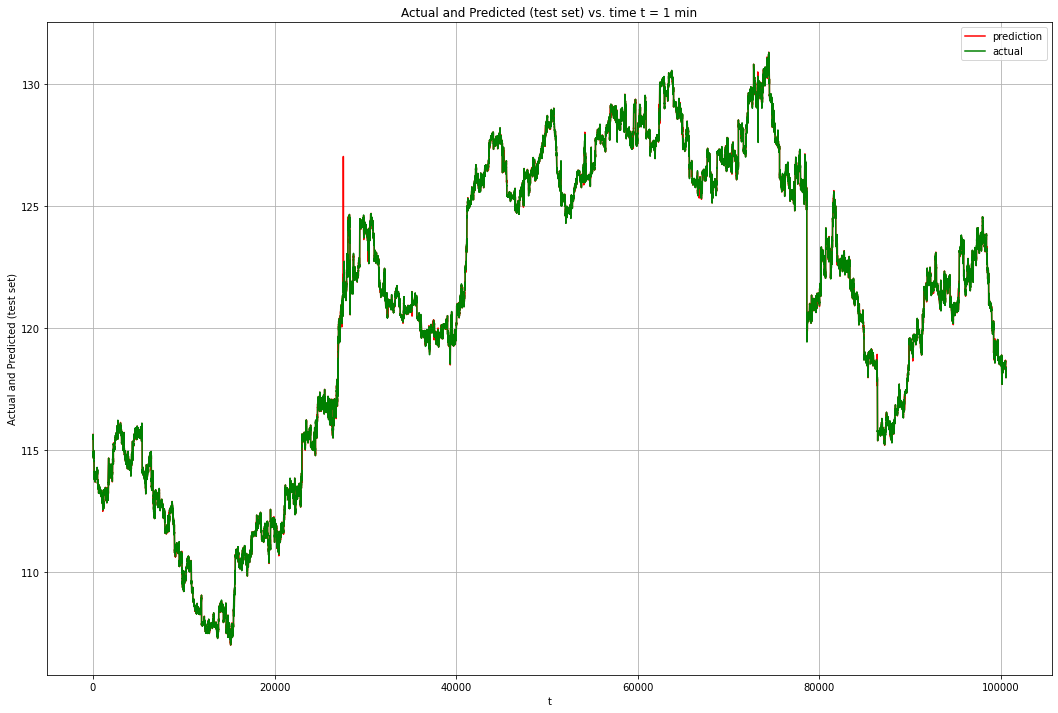

In [35]:
from sklearn import linear_model


def preprocess_df(df=None, target_column=None, verbose=False):
    try:
        if df is None or len(df) == 0 or target_column is None:
            raise Exception("params df and target_column cannot be None type")
        else:
            y = df[[target_column]]
            df = df.drop(target_column, axis=1)
            df.reset_index(inplace=True)
            df = df.drop('datetime', axis=1)
            if verbose:
                print(f"y:\n{y.head(3)}\n")
                print(f"y:\n{df.head(3)}")
            return df, y
    except Exception as e:
        msg = "error in create_train_test_set"
        raise e(msg)

def create_train_test_set(df=None, train_split=None, target_column='close', scale_data=False):
    """General function for splitting data into Xtrain, Xtest, ytrain, ytest"""
    try:
        if df is None or train_split is None or len(df) == 0:
            msg = "Params df and train_split cannot be None type"
            raise Exception(msg)
            
        df, y = preprocess_df(df=df, target_column=target_column)
        
        # Split the data into training and testing
        train_test_split = int(len(df) * train_split)
        Xtrain = np.array(df.iloc[:train_test_split, :])
        Xtest = np.array(df.iloc[train_test_split:, :]) 
        ytrain = np.array(y.iloc[:train_test_split])
        ytest = np.array(y.iloc[train_test_split:]) 
        
        if scale_data:
            #Scale Xtrain, Xtest
            Xscaler = MinMaxScaler(feature_range=(-1, 1)) # scale so that all the X data will range from 0 to 1
            Xscaler.fit(Xtrain)
            Xtrain = Xscaler.transform(Xtrain)
            Xscaler.fit(Xtest)
            Xtest = Xscaler.transform(Xtest)

            #Scale ytrain, ytest
            Yscaler = MinMaxScaler(feature_range=(-1, 1))
            Yscaler.fit(ytrain)
            ytrain = Yscaler.transform(ytrain)        
        return Xtrain, Xtest, ytrain, ytest, train_test_split
    except Exception as e:
        msg = "error in create_train_test_set"
        raise e(msg)


# Split the training and test data
df = pd.read_csv('./macro_data_df.csv', header=0, index_col='datetime')
train_split_size = 0.8
Xtrain, Xtest, ytrain, ytest, train_test_split = create_train_test_set(df=df, train_split=train_split_size)

# Create and train the model
regr = linear_model.LinearRegression()
regr.fit(Xtrain, ytrain)

# Evaluate accuracy on Xtest
yhat = regr.predict(Xtest)


# Compute the normalized MSE on the test data
RSS_test = np.sum((ytest - yhat)**2)
ytest_avg = np.sum(ytest) / len(ytest)
sample_variance_sqrd_test = np.sum((ytest - ytest_avg)**2)/len(ytest)
RSS_test_normalized = RSS_test / (len(ytrain) * sample_variance_sqrd_test)


print(f"\n\nNormalized RSS_test is {RSS_test_normalized}\n\n")


#Plot Actual and Predicted over time
plt.figure(figsize=(18, 12))
plt.plot(range(1, len(df.index[train_test_split:]) + 1), yhat, 'r', label='prediction')
plt.plot(range(1, len(df.index[train_test_split:]) + 1), ytest, 'g', label='actual')
plt.title('Actual and Predicted (test set) vs. time t = 1 min')
plt.xlabel('t')
plt.ylabel('Actual and Predicted (test set)')
plt.grid()
plt.legend(loc='upper right')
plt.show()

### Section C - Feature Selection: LASSO vs. Linear Regession

In this section, we assess the performance of LASSO regression versus linear regression for the purpose of feature selection. Specifically, both LASSO regression and OLS regression models were trained for 1-min, 5-min, 60-min, 120-min price partitions.  The weights of the features for the LASSO and OLS were used to filter the input features for training RNNs.  RNN training was performed separately on the LASSO and OLS feature sets.  For LASSO, non-zero regression weights were retained.  For OLS, features were retained based on a cutoff threshold of |+/-0.1|.

In [93]:
# Split the training and test data
df = pd.read_csv('./macro_data_df.csv', header=0, index_col='datetime')
train_split_size = 0.8

time_frames = [1, 5, 60, 120]
weights_for_rnn_training = []
lr_feature_paths = []

for timeframe_idx in range(len(time_frames)):
    df_tf = df.copy()
    df_tf = df_tf.iloc[::time_frames[timeframe_idx], :]
    
    Xtrain, Xtest, ytrain, ytest, train_test_split = create_train_test_set(df=df_tf, train_split=train_split_size)

    # Create and train the model
    regr = linear_model.LinearRegression()
    regr.fit(Xtrain, ytrain)
    
    model_weights = regr.coef_[0]
    
    important_weights = list(np.where(abs(model_weights) >= 0.01)[0])
    curr_columns = [c for c in list(df_tf.columns) if c != 'close']
    all_feature_cols = [c for c in curr_columns]
    important_features = [all_feature_cols[idx] for idx in list(important_weights)]
    print(f"\nKeeping following features ({time_frames[timeframe_idx]}-minute):\n{important_features}")
    weights_for_rnn_training.append(important_weights)
    
    
    df_reduced = df.loc[:, important_features]
    if 'close' not in list(df_reduced.columns):
        df_reduced['close'] = df['close']
    path = f'./{time_frames[timeframe_idx]}_lr_features.csv'
    df_reduced.to_csv(path_or_buf=path, index_label='datetime')
    print(f"saved features to {path}")
    lr_feature_paths.append(path)


Keeping following features (1-minute):
['open', 'high', 'low', 'vwap']
saved features to ./1_lr_features.csv

Keeping following features (5-minute):
['open', 'high', 'low']
saved features to ./5_lr_features.csv

Keeping following features (60-minute):
['open', 'high', 'low', 'HYG_open', 'HYG_high', 'HYG_low', 'HYG_close', 'VIXY_open', 'VIXY_low']
saved features to ./60_lr_features.csv

Keeping following features (120-minute):
['open', 'high', 'low', 'HYG_open', 'HYG_high', 'HYG_low', 'HYG_vwap', 'HYG_close', 'VIXY_high', 'VIXY_vwap']
saved features to ./120_lr_features.csv


In [84]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

train_split_size = 0.8

target_colummn = 'close'
df_lasso = pd.read_csv('./macro_data_df.csv', header=0, index_col='datetime')
df = df_lasso.copy()
# df, y = preprocess_df(df=df, target_column=target_colummn, verbose=False)
Xtrain, Xtest, ytrain, ytest, train_test_split = create_train_test_set(df=df, train_split=train_split_size)
df_postprocessing_cols = [col for col in list(df.columns)] + [target_colummn]

# First search for optimal alpha
nalpha = 50
alphas = np.logspace(-5, -1, nalpha)
rsq_lasso = np.zeros(nalpha)

count = 0
for count, alpha in enumerate(alphas):
    regr_lasso = Lasso(alpha, max_iter=1000, tol=0.01)
    regr_lasso.fit(Xtrain, ytrain)
    ytest = regr_lasso.predict(Xtest)
    rsq_lasso[count] = r2_score(ytest, yhat)
    count += 1

Max r^2 = 1.0
Optimal alpha (from LASSO regularization) = 0.0006250551925273969


Text(0, 0.5, 'R^2 Score')

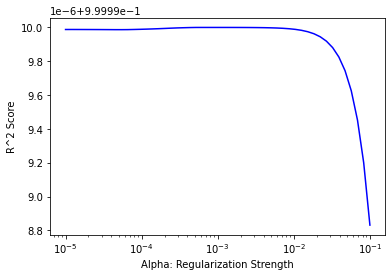

In [85]:
# Visualization of Optimal alpha via r squared plot (optimal alpha == max of r squared in plot)
plt.semilogx(alphas, rsq_lasso, 'b-')
opt_alpha = alphas[np.argmax(rsq_lasso)]

print(f'Max r^2 = {np.max(rsq_lasso)}')
print(f'Optimal alpha (from LASSO regularization) = {opt_alpha}')
plt.xlabel('Alpha: Regularization Strength')
plt.ylabel('R^2 Score')

In [86]:
# Now train LASSO with optimal alpha
regr_lasso = Lasso(opt_alpha, max_iter=10000, tol=0.1)
regr_lasso.fit(Xtrain, ytrain)
yhat = regr_lasso.predict(Xtest)

rsq_test = r2_score(ytest, yhat)
print(f'r^2 Test (using LASSO regularization) = {rsq_test}')

W_lasso = np.matrix.transpose(regr_lasso.coef_)
print(f'\n\nW = {W_lasso}\n\n')

Wrms_lasso = np.sqrt(W_lasso**2)
L0norm = np.linalg.norm(Wrms_lasso, ord=0)
print(f'Total no. of Non-Zero elements in Wrms (via LASSO) is {L0norm}\n\n')
zero_valued_idxs = list(np.where(Wrms_lasso == 0)[0])

remove_features_names = [df_postprocessing_cols[i] for i in zero_valued_idxs if df_postprocessing_cols[i] != 'close']
remove_features_idx = [i for i in zero_valued_idxs if df_postprocessing_cols[i] != 'close']
print(f"The features to be removed are:\n\n {remove_features_names}\n\n")

# Create temp df with reduced features from LASSO selection routine
df_temp = pd.read_csv('macro_data_df.csv', header=0, index_col='datetime')
all_feature_cols = [c for c in list(df_temp.columns)]
reduced_feature_cols = [col for col in all_feature_cols if col not in remove_features_names]
df_reduced = df_temp.loc[:, reduced_feature_cols]
df_reduced['close'] = df_lasso['close']
df_reduced.to_csv(path_or_buf='./reduced_macro_data_df.csv', index_label='datetime')

print(f"first 3 rows of df with reduced features: \n{df_reduced.head(3)}")

r^2 Test (using LASSO regularization) = 0.9999988315053304


W = [ 9.99971666e-01  1.19444852e-05  3.19648999e-06  0.00000000e+00
 -2.00319406e-08 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -5.81112688e-10 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.76096908e-10
  0.00000000e+00  1.06869214e-06  0.00000000e+00  4.63763779e-09
  5.40724647e-08 -3.55179817e-11  0.00000000e+00]


Total no. of Non-Zero elements in Wrms (via LASSO) is 10.0


The features to be removed are:

 ['vwap', 'HYG_open', 'HYG_high', 'HYG_low', 'HYG_volume', 'HYG_close', 'VIXY_open', 'VIXY_high', 'VIXY_low', 'VIXY_volume', 'SPY_open', 'SPY_volume']


first 3 rows of df with reduced features: 
                       open    high       low   volume    close  HYG_vwap  \
datetime                                                                    
2020-03-20 17:24:00  139.53  139.55  139.4583   9946.0  139.470     86.56   
2020-03-20 17:23:00  139.68  139.69  

### Section D - Neural Network Training (Linear Regression Features)

In Section C, we trained four linear regression models using the four different price partitions (1-min, 5-min, 60-min, 120-min).  The regression coefficients for each price partition were used to filter the feature set for RNN training. 

In this section, a RNN was trained using the OLS features for 1-min, 5-min, 60-min, and 120-min time intervals, and the LASSO feature set was used to train only on the 1-min price partition.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1000)              4020000   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 4,021,001
Trainable params: 4,021,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10997/10997 [==============================] - 177s 16ms/step - loss: 23.7156
Epoch 2/5
10997/10997 [==============================] - 176s 16ms/step - loss: 21.0469
Epoch 3/5
10997/10997 [==============================] - 176s 16ms/s

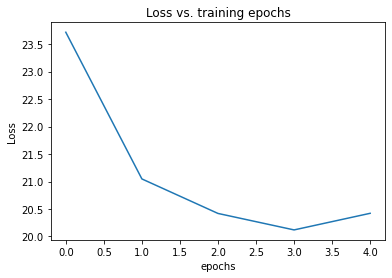

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1000)              4016000   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 4,017,001
Trainable params: 4,017,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10997/10997 [==============================] - 181s 16ms/step - loss: 19.3507
Epoch 2/5
10997/10997 [==============================] - 180s 16ms/step - loss: 16.6348
Epoch 3/5
10997/10997 [==============================] - 178s 16ms

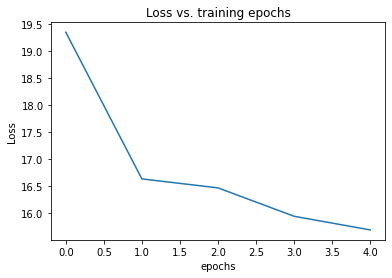

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1000)              4040000   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 4,041,001
Trainable params: 4,041,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10997/10997 [==============================] - 180s 16ms/step - loss: 28.6656
Epoch 2/5
10997/10997 [==============================] - 179s 16ms/step - loss: 27.3099
Epoch 3/5
10997/10997 [==============================] - 181s 16ms

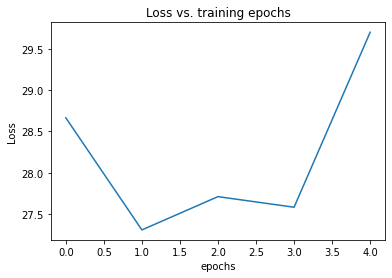

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1000)              4044000   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 4,045,001
Trainable params: 4,045,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10997/10997 [==============================] - 179s 16ms/step - loss: 29.2535
Epoch 2/5
10997/10997 [==============================] - 178s 16ms/step - loss: 21.7302
Epoch 3/5
10997/10997 [==============================] - 177s 16ms

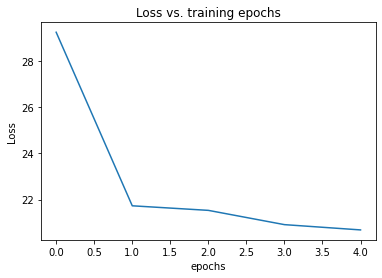

In [100]:
# Creates the RNN model
def create_model(output_units=1, lr=0.001, loss='mse', num_units=1000,
                 activation_func='relu', batch_size=32, dropout=0.1,
                alpha=0.5, n_inputs=None, n_features=None,
                 optimizer='adam', show_model_summary=True):
    try:
        if n_inputs is None or n_features is None:
            raise("n_inputs and n_features cannot be None type")
        else:
            adam = Adam(lr=lr)

            # Initialize the RNN
            model = Sequential()
            model.add(LSTM(units=num_units,
                           activation=activation_func,
                           input_shape=(n_inputs, n_features)))
            model.add(LeakyReLU(alpha=alpha))
            model.add(Dropout(dropout))
            model.add(Dense(units=output_units))

            # Compiling the RNN
            model.compile(optimizer, loss)
            if show_model_summary:
                model.summary()

            return model
    except Exception as e:
        msg = "Error in create_model"
        raise e(msg)

# clear keras session
K.clear_session()
        

# Split the training and test data
# df_1min = pd.read_csv('./reduced_macro_data_df.csv', header=0, index_col='datetime')
feature_regr_paths = ['./1_lr_features.csv',
                      './5_lr_features.csv',
                      './60_lr_features.csv',
                      './120_lr_features.csv']

time_frames = [1, 5, 60, 120]
cross_timeframe_dfs = []

# Load in the dfs from persisted in the feature selection section
for idx, feature_regr_path in enumerate(feature_regr_paths):
    new_df = pd.read_csv(feature_regr_path, header=0, index_col='datetime')
    cross_timeframe_dfs.append(new_df)
    
# Model & Training Parameters (n_inputs is the lookback of the RNN)
n_inputs = 5
batch_size = 32
epochs = 5
train_split_size = 0.7
test_set_per_tf = []
    
# Train 
for timeframe_idx in range(len(time_frames)):
    df = cross_timeframe_dfs[timeframe_idx].copy()
    Xtrain, Xtest, ytrain, ytest, train_test_split = create_train_test_set(df=df, train_split=train_split_size)
    n_features = Xtrain.shape[1]
    test_set_per_tf.append((Xtest, ytest))
    
    # Setup model & TimeseriesGenerator, and train the model
    model = create_model(n_inputs=n_inputs, n_features=n_features)
    generator = TimeseriesGenerator(Xtrain, ytrain, length=n_inputs, batch_size=batch_size)
    model.fit_generator(generator,epochs=epochs)
    
    print(f"model saved as model_tf_{time_frames[timeframe_idx]}")
    model.save(f"model_tf_{time_frames[timeframe_idx]}.h5")
    
    # Visualize the loss function over the training epochs
    loss_val_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_val_per_epoch)), loss_val_per_epoch)
    plt.title('Loss vs. training epochs')
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.show()

#### Section D.1 - Model Validation (Linear Regression Feature)

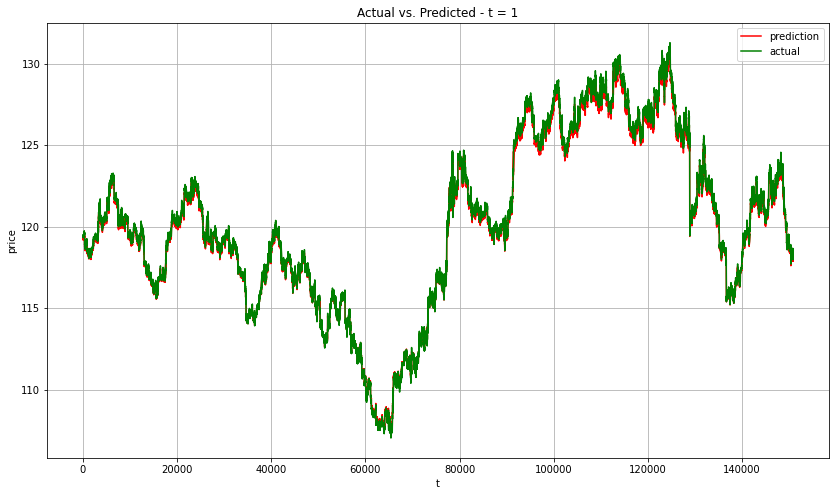

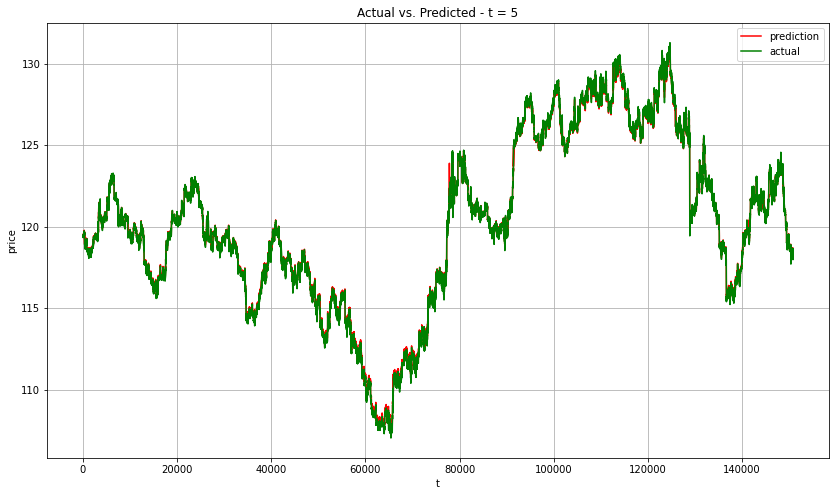

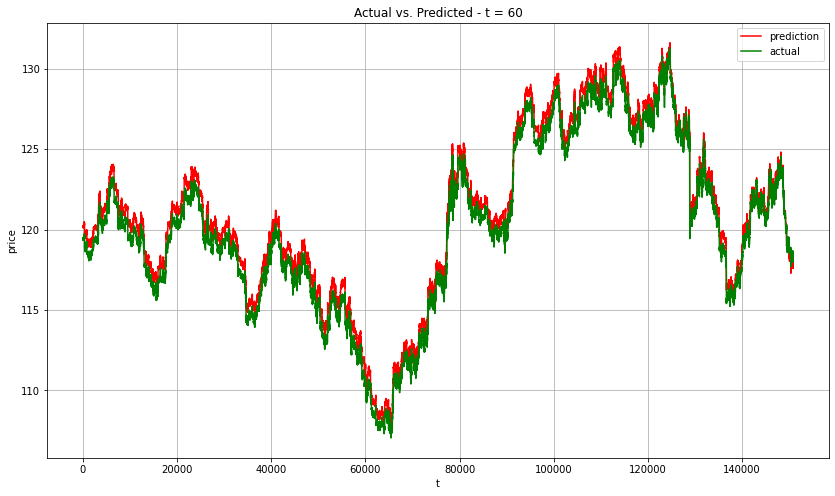

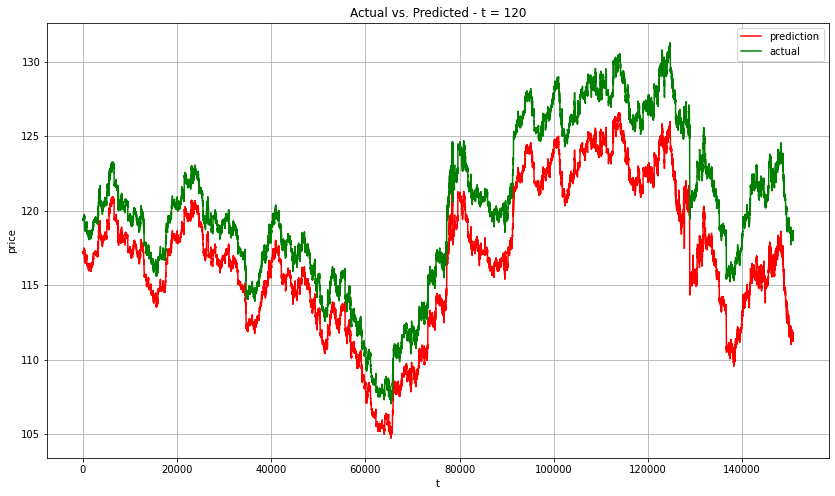

In [103]:
from tensorflow import keras
import pandas as pd
import numpy as np

results_per_tf = []

for test_set_idx in range(len(test_set_per_tf)):
    test_set = test_set_per_tf[test_set_idx]
    Xtest, ytest = test_set
    
    model = keras.models.load_model(f"model_tf_{time_frames[test_set_idx]}.h5")
    
    
    #Create a TimeseriesGenerator for the test data
    generator_test = TimeseriesGenerator(Xtest,
                                         np.zeros(len(Xtest)),
                                         length=n_inputs,
                                         batch_size=batch_size)

    # # Use the fitted RNN to generate predictions (yhat)
    yhat = model.predict(generator_test)
    yhat = yhat.ravel()
    ytest = ytest.ravel()
    results = pd.DataFrame({'y_true':ytest[n_inputs:],'y_pred':yhat})
    results_per_tf.append(results)

    #Plot Actual and Predicted over time
    plt.figure(figsize=(14, 8))
    plt.plot(range(1, len(yhat) + 1), yhat, 'r', label='prediction')
    plt.plot(range(1, len(ytest) + 1), ytest, 'g', label='actual')
    plt.title(f'Actual vs. Predicted - t = {time_frames[test_set_idx]}')
    plt.xlabel('t')
    plt.ylabel('price')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

#### Section D.2 - Neural Network Training Part II (LASSO Features)

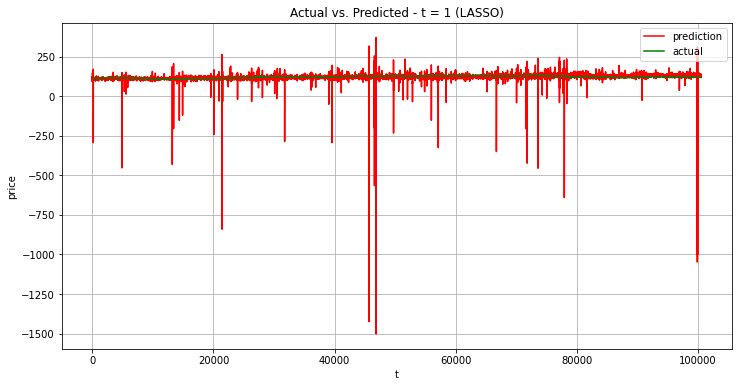

In [107]:
import datetime

loss_dict = {'model': [], 'Normalized RSS': []}

# Split the training and test data
df_lasso = pd.read_csv('reduced_macro_data_df.csv', header=0, index_col='datetime')
train_split_size = 0.8
Xtrain_lasso, Xtest_lasso, ytrain_lasso, ytest_lasso, train_test_split_lasso = create_train_test_set(df=df_lasso, train_split=train_split_size)


# Model & Training Parameters (n_inputs is the lookback of the RNN)
n_inputs = 5
n_features = Xtrain_lasso.shape[1]
batch_size = 32
epochs = 5

start = datetime.datetime.now()
print(start)
print('')

# Setup model & TimeseriesGenerator, and train the model
model_lasso = create_model(n_inputs=n_inputs, n_features=n_features)
generator_lasso = TimeseriesGenerator(Xtrain_lasso, ytrain_lasso, length=n_inputs, batch_size=batch_size)
model_lasso.fit_generator(generator_lasso,epochs=epochs)
model_lasso.save('model_tf_1_lasso.h5')


# Visualize the loss function over the training epochs
loss_val_per_epoch_lasso = model_lasso.history.history['loss']
plt.plot(range(len(loss_val_per_epoch_lasso)), loss_val_per_epoch_lasso)
plt.title('Loss vs. training epochs (LASSO)')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.show()

# Model Validation
loss_dict = {'model': [], 'Normalized RSS': []}
#Create a TimeseriesGenerator for the test data
generator_test_lasso = TimeseriesGenerator(Xtest_lasso,
                                     np.zeros(len(Xtest_lasso)),
                                     length=n_inputs,
                                     batch_size=batch_size)

# # Use the fitted RNN to generate predictions (yhat)
yhat_lasso = model_lasso.predict(generator_test_lasso)
yhat_lasso = yhat_lasso.ravel()
ytest_lasso = ytest_lasso.ravel()[n_inputs:]
results_lasso = pd.DataFrame({'y_true':ytest_lasso,'y_pred':yhat_lasso})

# Compute the normalized MSE on the test data
RSS_test_lasso = np.sum((ytest_lasso - yhat_lasso)**2)
ytest_avg_lasso = np.sum(ytest_lasso) / len(ytest_lasso)
sample_variance_sqrd_test_lasso = np.sum((ytest_lasso - ytest_avg_lasso)**2)/len(ytest_lasso)
RSS_test_normalized_lasso = RSS_test_lasso / (len(ytrain_lasso) * sample_variance_sqrd_test_lasso)
loss_dict['model'].append("1_min_LASSO")
loss_dict['Normalized RSS'].append(RSS_test_normalized_lasso)


#Plot Actual and Predicted over time
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(yhat_lasso) + 1), yhat_lasso, 'r', label='prediction')
plt.plot(range(1, len(ytest_lasso) + 1), ytest_lasso, 'g', label='actual')
plt.title(f'Actual vs. Predicted - t = 1 (LASSO)')
plt.xlabel('t')
plt.ylabel('price')
plt.grid()
plt.legend(loc='upper right')
plt.show()

### Section E - Comparative Evaluation of Model Quality

In this section, the RSS for the five RNN models were computed and normalized RSS. As shown in the table, the RNN trained using the LASSO feaure was significantly worse than all of the other RNN models trained using the linear regression features. One unexpected result was that the 5-min RNN had a lower normalized RSS score than the 1-min RNN.

In [110]:
# model_idx = 0

for result in results_per_tf:
    ytest, yhat = np.array(result['y_true'].values), np.array(result['y_pred'].values)
    # Compute the normalized MSE on the test data
    RSS_test = np.sum((ytest - yhat)**2)
    ytest_avg = np.sum(ytest) / len(ytest)
    sample_variance_sqrd_test = np.sum((ytest - ytest_avg)**2)/len(ytest)
    RSS_test_normalized = RSS_test / (len(ytrain) * sample_variance_sqrd_test)
    loss_dict['model'].append(f"{time_frames[model_idx]}_min")
    loss_dict['Normalized RSS'].append(RSS_test_normalized)
    model_idx += 1


#Table of loss functions per model
df_loss = pd.DataFrame(data=loss_dict)
df_loss.set_index('model', inplace=True)
df_loss.to_csv('./rnn_loss_per_tf.csv', index_label='model')
df_loss.iloc[:5, :]

,Normalized RSS
model,
1_min_LASSO,1.848392
1_min,0.000956
5_min,0.000285
60_min,0.008606
120_min,0.195222


### Section F - Analysis and Conclusion

In this project, we employed two feature selection techniques, linear regression (OLS) and LASSO regression, to determine the features to train the neural networks for timeseries forecasting.  Each of the neural network models that were trained using OLS features (4, 3, 9 and 10 total features, respectively for each price partition) outperformed the LASSO-trained 1-min price partition neural network (12 features). 

One unexpected result was the 5-min OLS model contained only three features: open, high, low. The corresponding 5-min RNN trained on the OLS features also had the lowest normalized RSS score (lower than the 1-min by a factor of almost 4). This result suggests that the 5-min RNN, with a very simple feature set, may be the highest quality model for this asset and task. 

The 60-min and 120-min OLS models contained many more features than the 1-min and 5-min OLS models.  The 60-min and 120-min RNNs performed significantly worse than the 1-min and 5-min RNNs.  Further analysis using percent change between price periods and volatility measures across price partitions (time periods) will validate the price partition  - in this experiment, the 5-min price parition performed best - that is optimal for the gold asset or any other assets that are tested using this framework.